# Practical 2: Dask with images

In the previous practical, we've seen that dask can help us parallelise computations on arrays. This can be useful for many operations typically performed on arrays like filtering.

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x12f300510>)

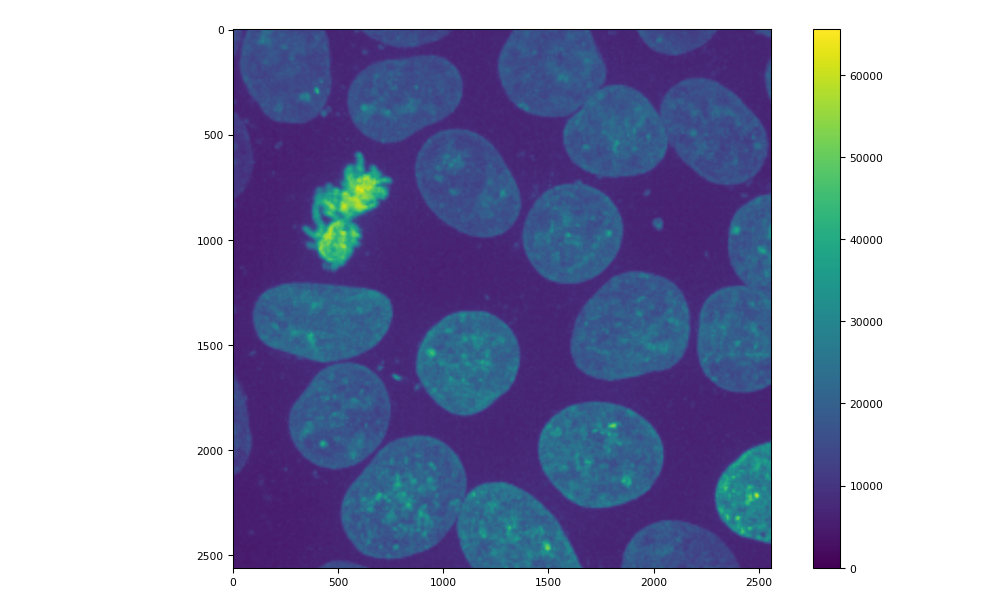

In [1]:
# Let's load an example image

import numpy as np
from skimage import data
from scipy import ndimage
import tifffile

%matplotlib ipympl

img = data.cells3d()
img = img.max(0)[1] # take only one channel and max project
img = ndimage.zoom(img, 10, order=1) # zoom in

tifffile.imshow(img)

How long does a gaussian filter take when applied to the entire image?

In [3]:
%%timeit -r 3

ndimage.gaussian_filter(img, sigma=5, mode='constant')

108 ms ± 3.16 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


What if we subdivide the array into chunks and apply this filter to each chunk?

In [4]:
import dask.array as da

img_da = da.from_array(img,
                       chunks=(500, 500),
                       )
img_da

dask.array<array, shape=(2560, 2560), dtype=uint16, chunksize=(500, 500), chunktype=numpy.ndarray>

### `map_blocks`
We can use `dask.array.map_blocks` to apply a function to each chunk (or block) of the dask array.

In [5]:
filtered = da.map_blocks(
            ndimage.gaussian_filter, # the function to apply to each chunk
            img_da, # the array to apply the function to
            sigma=5, # arguments to the function
            mode='constant',
            )
filtered

dask.array<gaussian_filter, shape=(2560, 2560), dtype=uint16, chunksize=(500, 500), chunktype=numpy.ndarray>

Does this improve the timing?

In [6]:
%%timeit -r 3

filtered.compute(scheduler='threads')

33.9 ms ± 1.1 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [7]:
%%timeit -r 3

filtered.compute(scheduler='processes')

581 ms ± 29.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Performance comparison: Applying the gaussian filter on each funk is faster when using multi-threading than when using multi-processing.

Why is this? While threads share memory, different processes need to send data back and forth, which can create considerable overhead.

Let's have a look at the output image.

entire image
dask.array.map_blocks


(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x17f8cb0d0>)

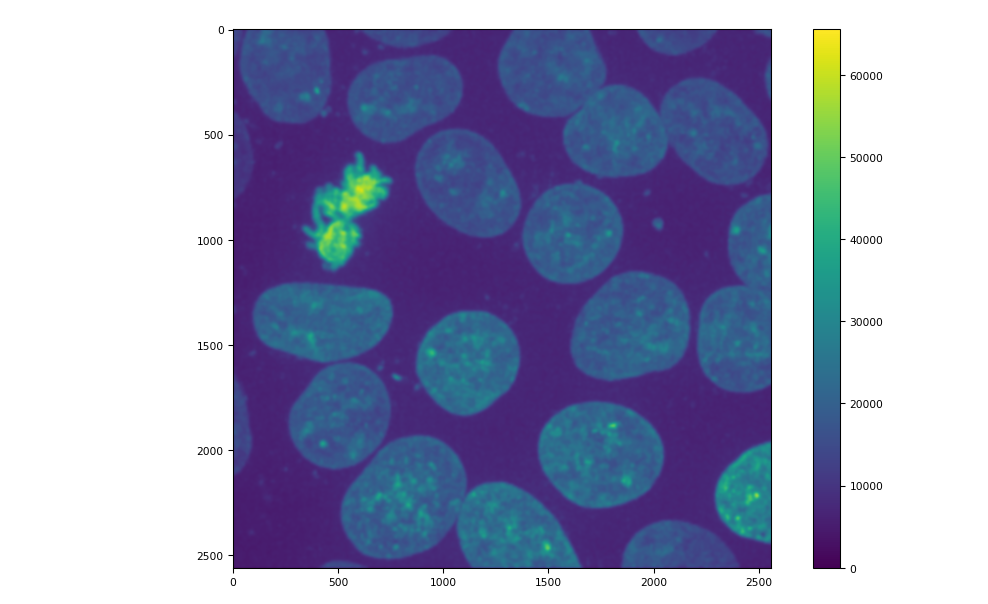

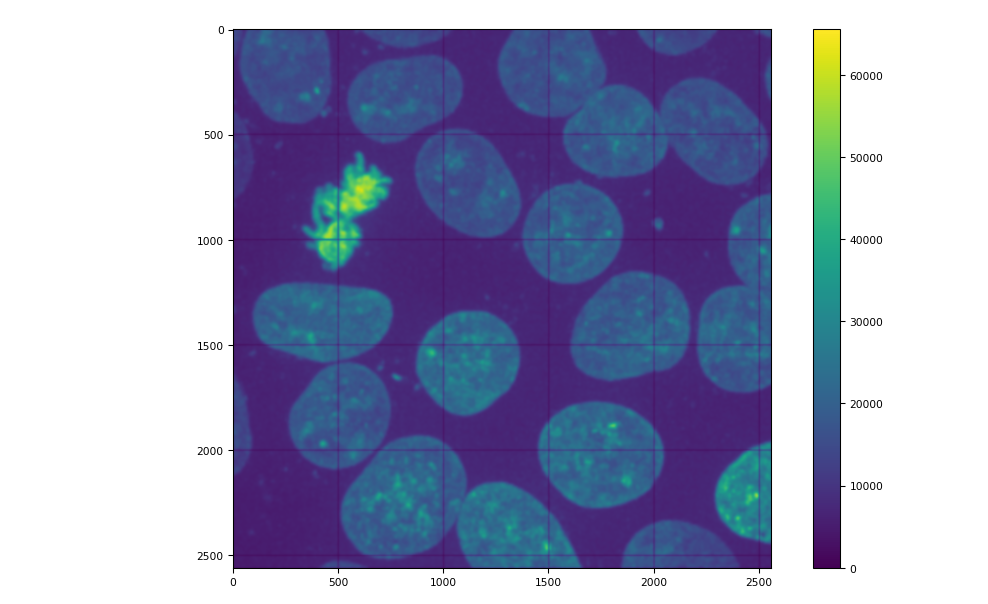

In [8]:
print('entire image')
filtered_ndimage = ndimage.gaussian_filter(img, sigma=5, mode='constant')
tifffile.imshow(filtered_ndimage)

print('dask.array.map_blocks')
tifffile.imshow(filtered)

We can prevent these border artefacts by using `map_overlap` instead of `map_blocks`.

This:
1) adds neighboring chunk values to the borders of each chunk)
2) applies map_blocks as before
3) trims the previously added overlap from each chunk

In [9]:
filtered_overlap = \
    da.map_overlap(
            ndimage.gaussian_filter, # the function to apply to each chunk
            img_da, # the array to apply the function to
            sigma=5, # arguments to the function
            mode='constant',
            depth=11,
            )
filtered_overlap

dask.array<_trim, shape=(2560, 2560), dtype=uint16, chunksize=(500, 500), chunktype=numpy.ndarray>

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x17fa88e10>)

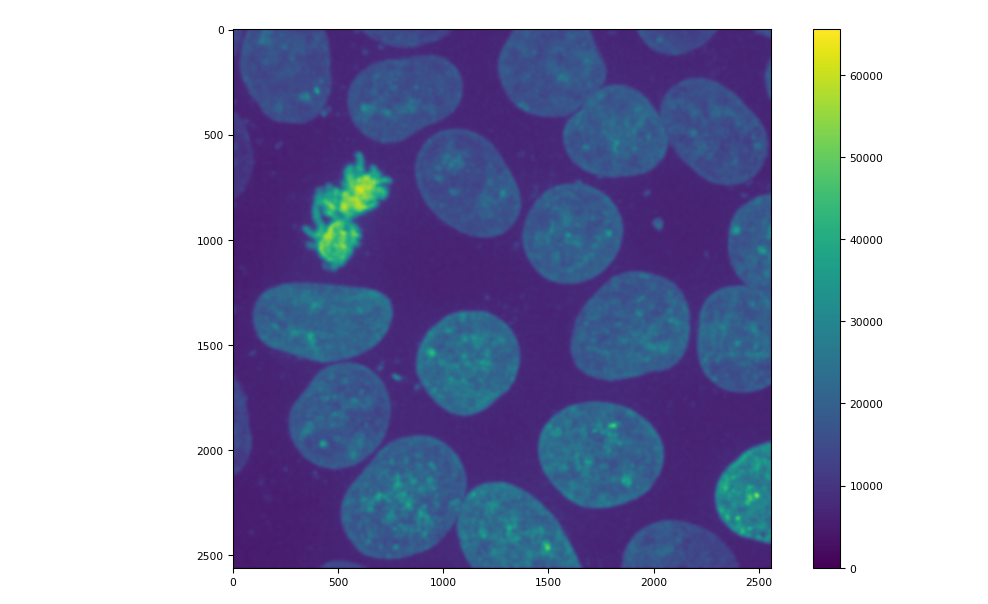

In [10]:
tifffile.imshow(filtered_overlap.compute())

In [11]:
%%timeit -r 3
filtered_overlap.compute(scheduler='threads')

53.3 ms ± 4.92 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


## dask-image

There's a python package which automatically deals with these border effects and other problems that can occur when applying the functions available from scipy.ndimage to tiled dask arrays.

https://image.dask.org/en/latest/

The available `ndimage` functions:
https://image.dask.org/en/latest/coverage.html

Among others:
- affine_transform
- label
- ...

In [11]:
from dask_image import ndfilters

filtered_di = ndfilters.gaussian_filter(img_da, sigma=5, mode='constant')
filtered_di

dask.array<_trim, shape=(2560, 2560), dtype=uint16, chunksize=(500, 500), chunktype=numpy.ndarray>

In [12]:
tifffile.imshow(filtered_di.compute())

<IPython.core.display.Javascript object>

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x125d63410>)

In [13]:
%%timeit -r 3
filtered_di.compute()

53.8 ms ± 2.36 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


## More dask-image features

### Connected components

/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/tifffile/tifffile.py:24941: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  Slider(


(<Figure size 988.8x604.8 with 3 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x17fa55210>)

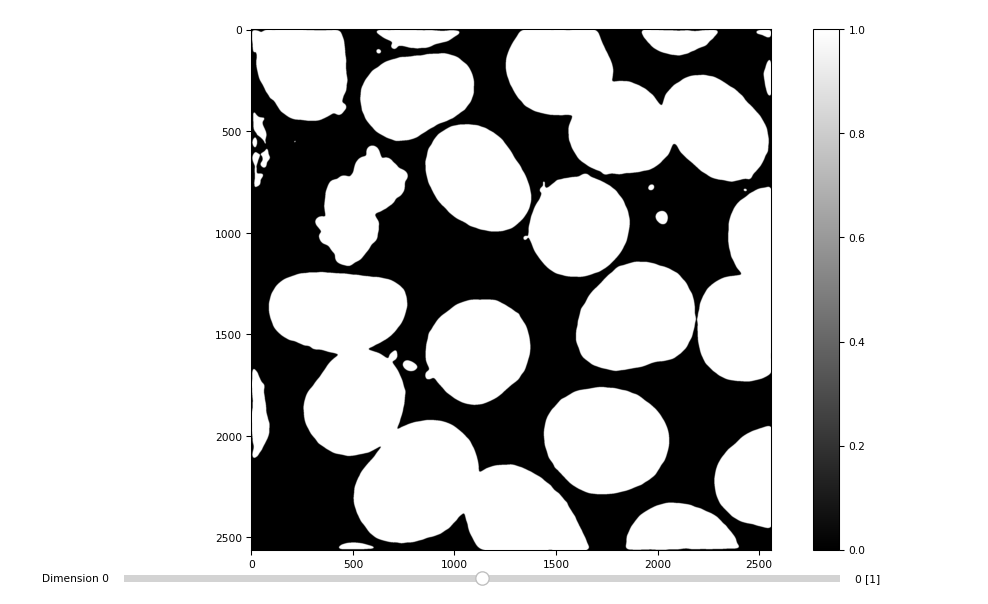

In [ ]:
from dask_image import ndfilters

img_da = da.from_array(img, chunks=500)
seg = (ndfilters.gaussian_filter(img_da, sigma=10, mode='constant') > 10000)

tifffile.imshow(seg)

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x17fedfb50>)

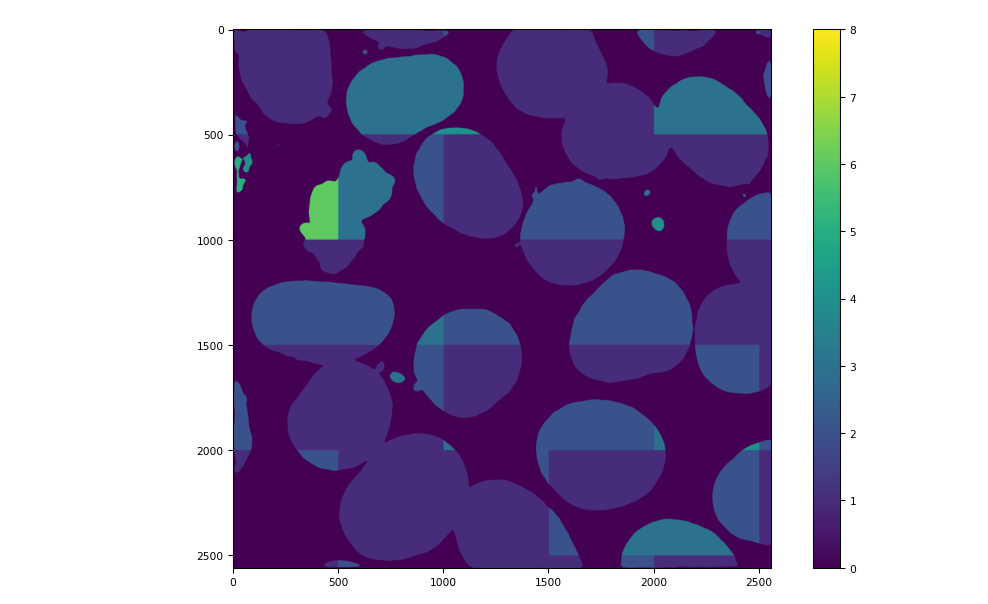

In [13]:
# Let's calculate connected components on each chunk of the segmentation image

def connected_components(im):
    return ndimage.label(im)[0]

labels = seg.map_blocks(connected_components)

tifffile.imshow(labels)

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x17fa991d0>)

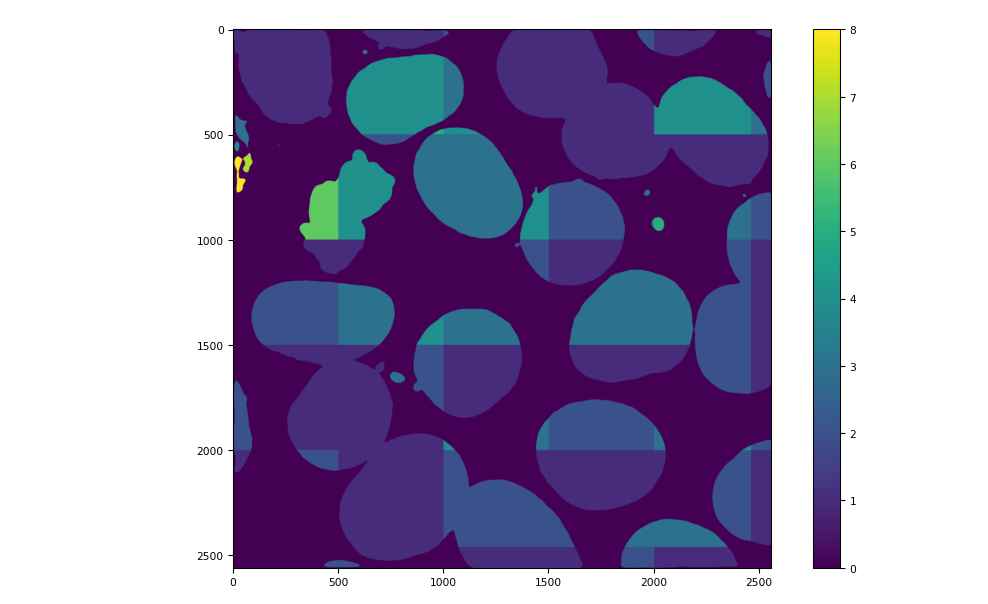

In [14]:
# Using overlap does not help in this case

def connected_components(im):
    return ndimage.label(im)[0]

labels = seg.map_overlap(
    connected_components,
    depth=100,
)
tifffile.imshow(np.array(labels))

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x2bb851a10>)

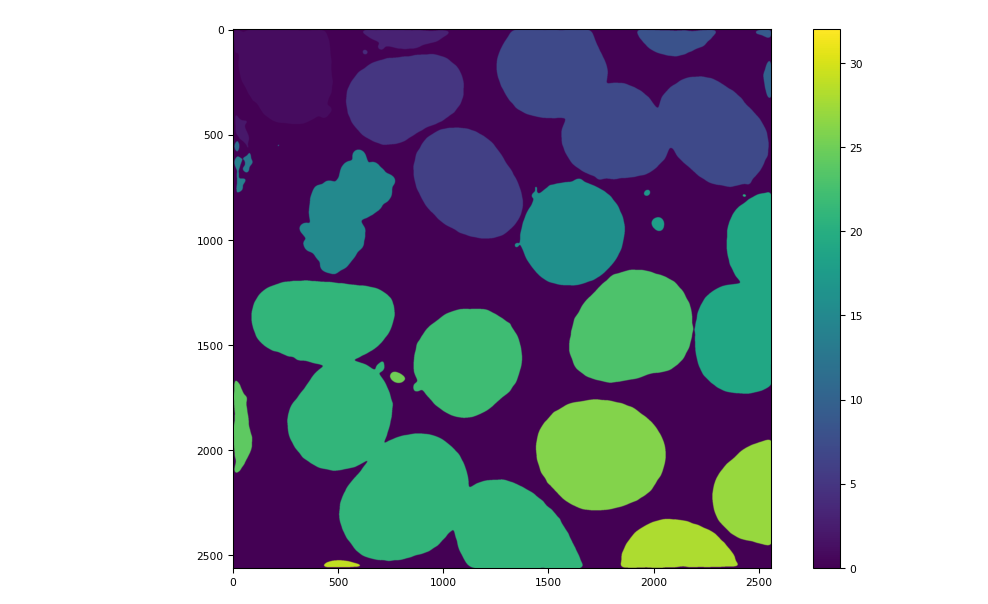

In [57]:
# dask-image implements connected components

from dask_image import ndmeasure

labels, N = ndmeasure.label(seg)

tifffile.imshow(labels)

### Connected components is slower with dask than with scipy

In [77]:
%%timeit -r 3

ndimage.label(img_da)

35.4 ms ± 6.49 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [81]:
%%timeit -r 3

ndmeasure.label(img_da)[0].compute()

149 ms ± 4.92 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


### Extracting features

dask-image doesn't have a direct equivalent to `skimage.measure.regionprops`, but we can use `dask-image` to compute the connected components and then use `ndmeasure.mean` or `ndmeasure.area` to compute the mean or area of each region.

In [85]:
mean_intensities = ndmeasure.mean(
    image=img_da,
    label_image=labels,
    index=range(1, N+1)
)

mean_intensities#.compute()

dask.array<getitem, shape=(29,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>

In [90]:
areas = ndmeasure.area(
    image=img_da > 0,
    label_image=labels,
    index=range(1, N+1)
)

areas#.compute()

dask.array<getitem, shape=(29,), dtype=int64, chunksize=(1,), chunktype=numpy.ndarray>

In [95]:
from dask import dataframe as dd

# make a dataframe with the mean intensities and areas
df = dd.from_array(np.column_stack((mean_intensities, areas)),
                    columns=['mean_intensity', 'area'],
                    )
df#.compute()

/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.column_stack` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


Dask DataFrame Structure:
              mean_intensity     area
npartitions=1                        
0                    float64  float64
28                       ...      ...
Dask Name: fromarray, 1 expression
Expr=FromArray(3afbd0e)

### Affine transformations

In [16]:
# Define a transformation

from scipy.spatial.transform import Rotation as R

# rotation
matrix = R.from_rotvec(np.pi/4. * np.array([0, 0, 1])).as_matrix()[:2, :2]
offset = np.array([1200., -600])

print('Matrix:', matrix)
print('Offset:', offset)

Matrix: [[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
Offset: [1200. -600.]


(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x17fa7db90>)

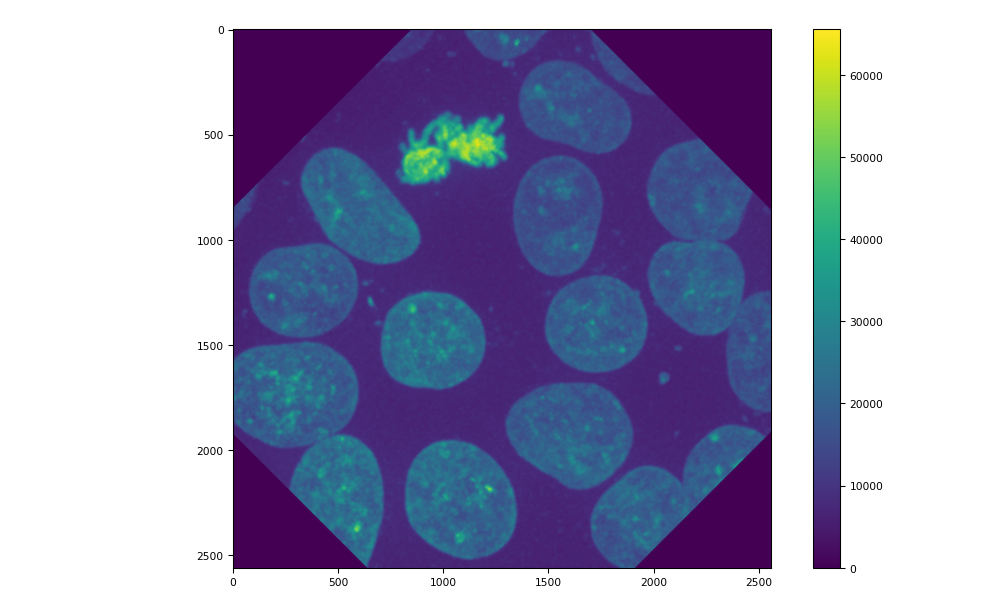

In [17]:
# Transform the image using plain scipy

img_t = ndimage.affine_transform(
    img,
    matrix=matrix,
    offset=offset,
    order=1, # linear interpolation
    )

tifffile.imshow(img_t)

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x17ff9ed10>)

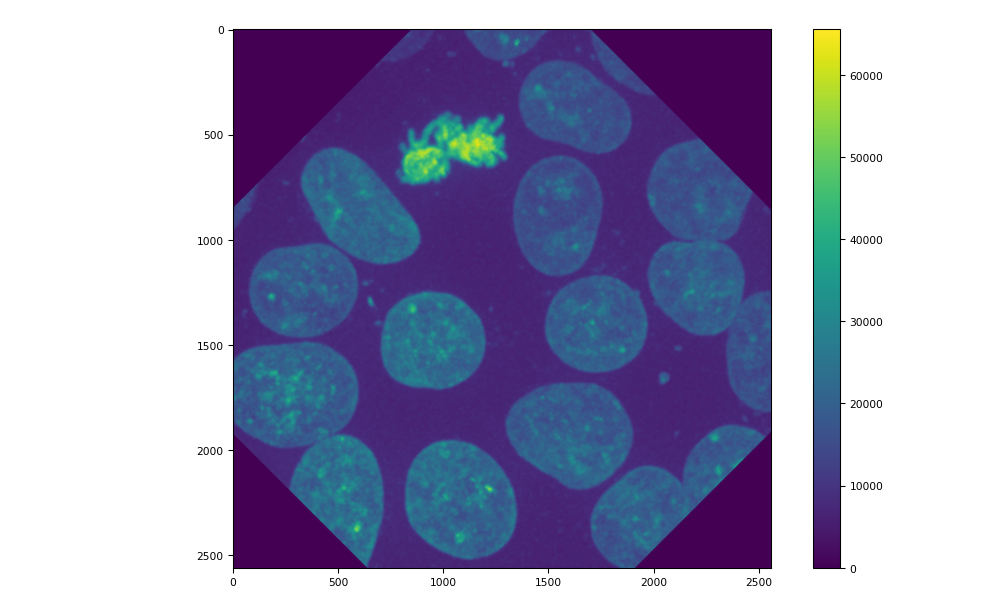

In [18]:
# Transform the image using dask_image.ndinterp.affine_transformation

from dask_image import ndinterp

img_t = ndinterp.affine_transform(
    img_da,
    matrix=matrix,
    offset=offset,
    order=1, # linear interpolation
    output_chunks=500,
    ).compute()
    
tifffile.imshow(img_t)

Performance comparison

In [19]:
%%timeit -r 1

img_t = ndimage.affine_transform(
    img,
    matrix=matrix,
    offset=offset,
    order=1, # linear interpolation
    )

150 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [20]:
%%timeit -r 1

img_t = ndinterp.affine_transform(
    img_da,
    matrix=matrix,
    offset=offset,
    order=1, # linear interpolation
    output_chunks=500,
    ).compute()

57.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


## Excercise: Apply a median filter

In [23]:
filtered = ...